In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.model_build import *
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 500
T = 1000
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


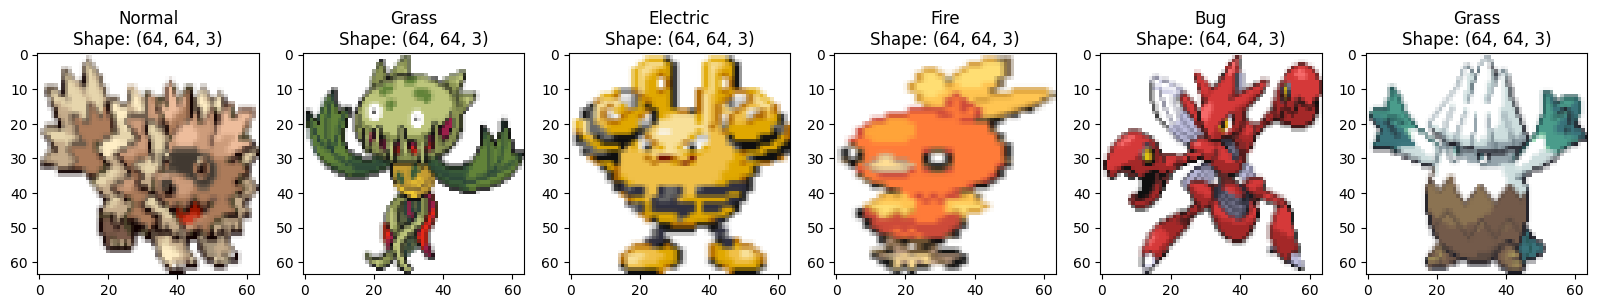

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [5]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES, num_channels=128, embedding_dim=128)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/500


I0000 00:00:1715272865.427271    7069 service.cc:145] XLA service 0x78f380002c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715272865.427294    7069 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1715272866.001626    7069 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1715272868.031277    7194 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6896', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1715272868.278081    7191 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6896', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1715272869.534813    7185 asm_compiler.cc:369] ptxas war

127/127 ━━━━━━━━━━━━━━━━━━━━ 86s 328ms/step - loss: 0.5909
Epoch 2/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.1676
Epoch 3/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.1577
Epoch 4/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.1627
Epoch 5/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.1207
Epoch 6/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.1012
Epoch 7/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.1045
Epoch 8/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.1303
Epoch 9/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.1158
Epoch 10/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.1089
Epoch 11/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.0766
Epoch 12/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - loss: 0.1314
Epoch 13/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - loss: 0.0908
Epoch 14/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0966
Epoch 15/500


Sampling sprite: 1000it [01:00, 16.61it/s]                        


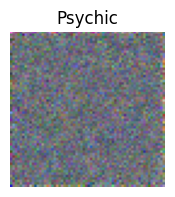

127/127 ━━━━━━━━━━━━━━━━━━━━ 103s 815ms/step - loss: 0.1105
Epoch 21/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.1237
Epoch 22/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0883
Epoch 23/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.1195
Epoch 24/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0910
Epoch 25/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 0.1013
Epoch 26/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0889
Epoch 27/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0799
Epoch 28/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 334ms/step - loss: 0.0534
Epoch 29/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0874
Epoch 30/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 337ms/step - loss: 0.0869
Epoch 31/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0561
Epoch 32/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 0.0664
Epoch 33/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.1017
Epoc

Sampling sprite: 1000it [00:58, 17.07it/s]                        


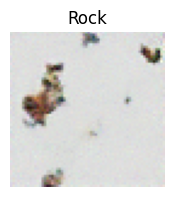

127/127 ━━━━━━━━━━━━━━━━━━━━ 102s 803ms/step - loss: 0.0532
Epoch 41/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0674
Epoch 42/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.1083
Epoch 43/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.0594
Epoch 44/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0609
Epoch 45/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0570
Epoch 46/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 0.0833
Epoch 47/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0630
Epoch 48/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0626
Epoch 49/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0710
Epoch 50/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0855
Epoch 51/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - loss: 0.0587
Epoch 52/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - loss: 0.0675
Epoch 53/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0653
Epoc

Sampling sprite: 1000it [00:58, 17.04it/s]                        


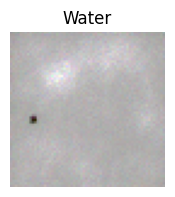

127/127 ━━━━━━━━━━━━━━━━━━━━ 102s 803ms/step - loss: 0.0779
Epoch 61/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0514
Epoch 62/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 328ms/step - loss: 0.0572
Epoch 63/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0611
Epoch 64/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.0702
Epoch 65/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.0661
Epoch 66/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.0855
Epoch 67/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0702
Epoch 68/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.0595
Epoch 69/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0736
Epoch 70/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0733
Epoch 71/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0594
Epoch 72/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0730
Epoch 73/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0624
Epoc

Sampling sprite: 1000it [00:59, 16.95it/s]                        


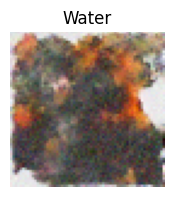

127/127 ━━━━━━━━━━━━━━━━━━━━ 102s 806ms/step - loss: 0.0485
Epoch 81/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0717
Epoch 82/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0881
Epoch 83/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.0573
Epoch 84/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0615
Epoch 85/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.0664
Epoch 86/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 0.0470
Epoch 87/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - loss: 0.0627
Epoch 88/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 334ms/step - loss: 0.0447
Epoch 89/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 45s 357ms/step - loss: 0.0512
Epoch 90/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - loss: 0.0572
Epoch 91/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - loss: 0.0659
Epoch 92/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 339ms/step - loss: 0.0660
Epoch 93/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 44s 345ms/step - loss: 0.0751
Epoc

Sampling sprite: 1000it [00:58, 17.01it/s]                        


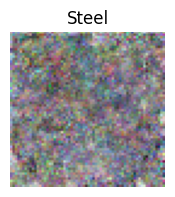

127/127 ━━━━━━━━━━━━━━━━━━━━ 102s 806ms/step - loss: 0.0477
Epoch 101/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0487
Epoch 102/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0629
Epoch 103/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0646
Epoch 104/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0635
Epoch 105/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0551
Epoch 106/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 0.0526
Epoch 107/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0716
Epoch 108/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0457
Epoch 109/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.0512
Epoch 110/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0501
Epoch 111/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0469
Epoch 112/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0818
Epoch 113/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss

In [6]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
model.plot_samples(6, "Fire")
model.plot_samples(6, "Water")
model.plot_samples(6, "Grass")

In [ ]:
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 1100
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm_attention_time_sin"

save_model(model, model_name)

/home/pqlza/.local/lib/python3.11/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


Model diffusion_32_64_1100_500_linear_ddpm_attention_time_sin, saved successfully!


In [ ]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

TypeError: <class 'src.model.overfitting_test.DiffusionModel'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'src.model.overfitting_test', 'class_name': 'DiffusionModel', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'DiffusionModel', 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999747378752e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'name': 'mean_squared_error', 'reduction': 'sum_over_batch_size'}, 'registered_name': None}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class 'src.model.overfitting_test.DiffusionModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of DiffusionModel from its config.

Received config={'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: DiffusionModel.__init__() got an unexpected keyword argument 'trainable'

[BACK TO TOP](#top)